In [1]:
from enum import auto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics  import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [2]:
# Bỏ qua hàng đầu tiên, dùng hàng 2 làm header
df = pd.read_csv("SWAT.csv",header=1, low_memory=False)

In [3]:
time_candidates = [c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
if not time_candidates:
    timestamp_col = df.columns[0]
else:
    timestamp_col = time_candidates[0]

df = df[~df[timestamp_col].astype(str).str.lower().eq(timestamp_col.lower())]
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)
df = df.dropna(subset=[timestamp_col])
df = df.set_index(timestamp_col)

print("Cột thời gian được sử dụng:", timestamp_col)

Cột thời gian được sử dụng: GMT +0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12688\1033324384.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)


In [4]:
attack_periods = [
    # Attack 1: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:08:46', '2019-07-20 07:10:31'),
    # Attack 2: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:15:00', '2019-07-20 07:19:32'),
    # Attack 3: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:26:57', '2019-07-20 07:30:48'),
    # Attack 4: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:38:50', '2019-07-20 07:46:20'),
    # Attack 5: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:54:00', '2019-07-20 07:56:00'),
    # Attack 6: 16h (GMT+8) -> 8h (GMT+0)
    ('2019-07-20 08:02:56', '2019-07-20 08:16:18')
]

attack_datetime_periods = [
    (pd.to_datetime(start).tz_localize("UTC"), pd.to_datetime(end).tz_localize("UTC"))
    for start, end in attack_periods
]

df['Attack'] = 0
for start, end in attack_datetime_periods:
    df.loc[start:end, 'Attack'] = 1

print("Số mẫu Attack:", df['Attack'].sum())
print("Tỷ lệ Attack:", df['Attack'].mean() * 100)

Số mẫu Attack: 1981
Tỷ lệ Attack: 13.210189383835688


In [5]:
plt.rcParams['figure.figsize'] = (15, 5)
status_cols = [col for col in df.columns if df[col].astype(str).str.contains("Active|Inactive", case=False).any()]

print("\n Các cột có Active/Inactive:", status_cols)

for col in status_cols:
    df[col] = df[col].map({'Active': 1, 'Inactive': 0})

# print(df[status_cols].head())

target_column = 'Attack'
feature_columns = df.columns.drop(target_column)

for col in feature_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

feature_std = df[feature_columns].std()
useless_columns = feature_std[feature_std == 0].index

if not useless_columns.empty:
    print("\nCác cột không có biến thiên (std=0) và có thể loại bỏ:")
    print(list(useless_columns))
    print("Số cột bị loại bỏ:", len(useless_columns))
    # df.drop(columns=useless_columns, inplace=True)
else:
    print("\nKhông có cột nào bị loại bỏ do không có biến thiên.")


 Các cột có Active/Inactive: ['LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']

Các cột không có biến thiên (std=0) và có thể loại bỏ:
['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']
Số cột bị loại bỏ: 33


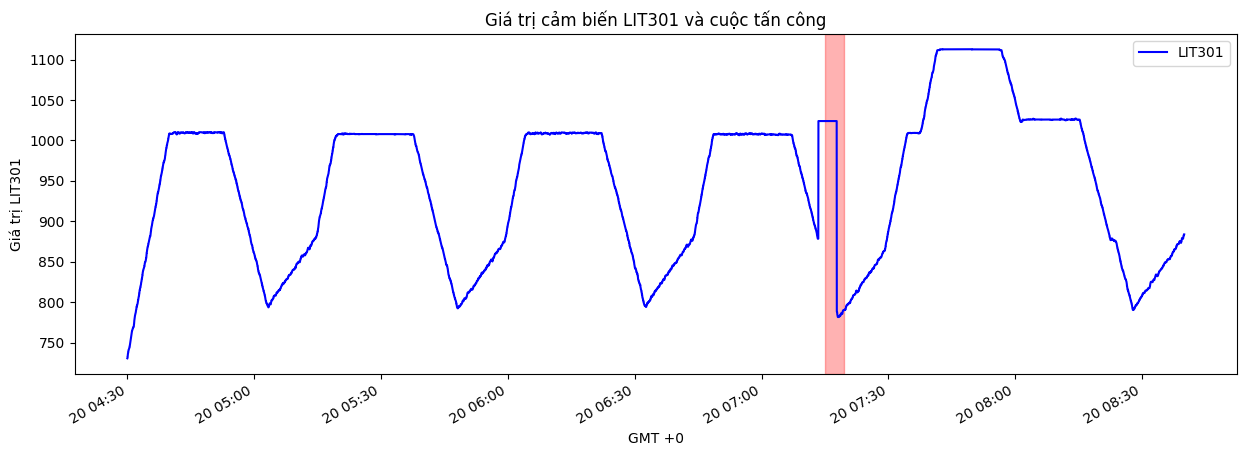

In [6]:
# --------------------------------------------------------------------------------
# Visualize attack periods on a specific sensor
fig, ax = plt.subplots()

df['LIT 301'].plot(ax=ax, label='LIT301', color='blue')

start,end = attack_datetime_periods[1]
ax.axvspan(start, end, color='red', alpha=0.3, label ='_nolegend_')

ax.set_title('Giá trị cảm biến LIT301 và cuộc tấn công')
ax.set_ylabel('Giá trị LIT301')
ax.legend()
plt.show()


Không tìm thấy cột nào chứa toàn giá trị NaN.


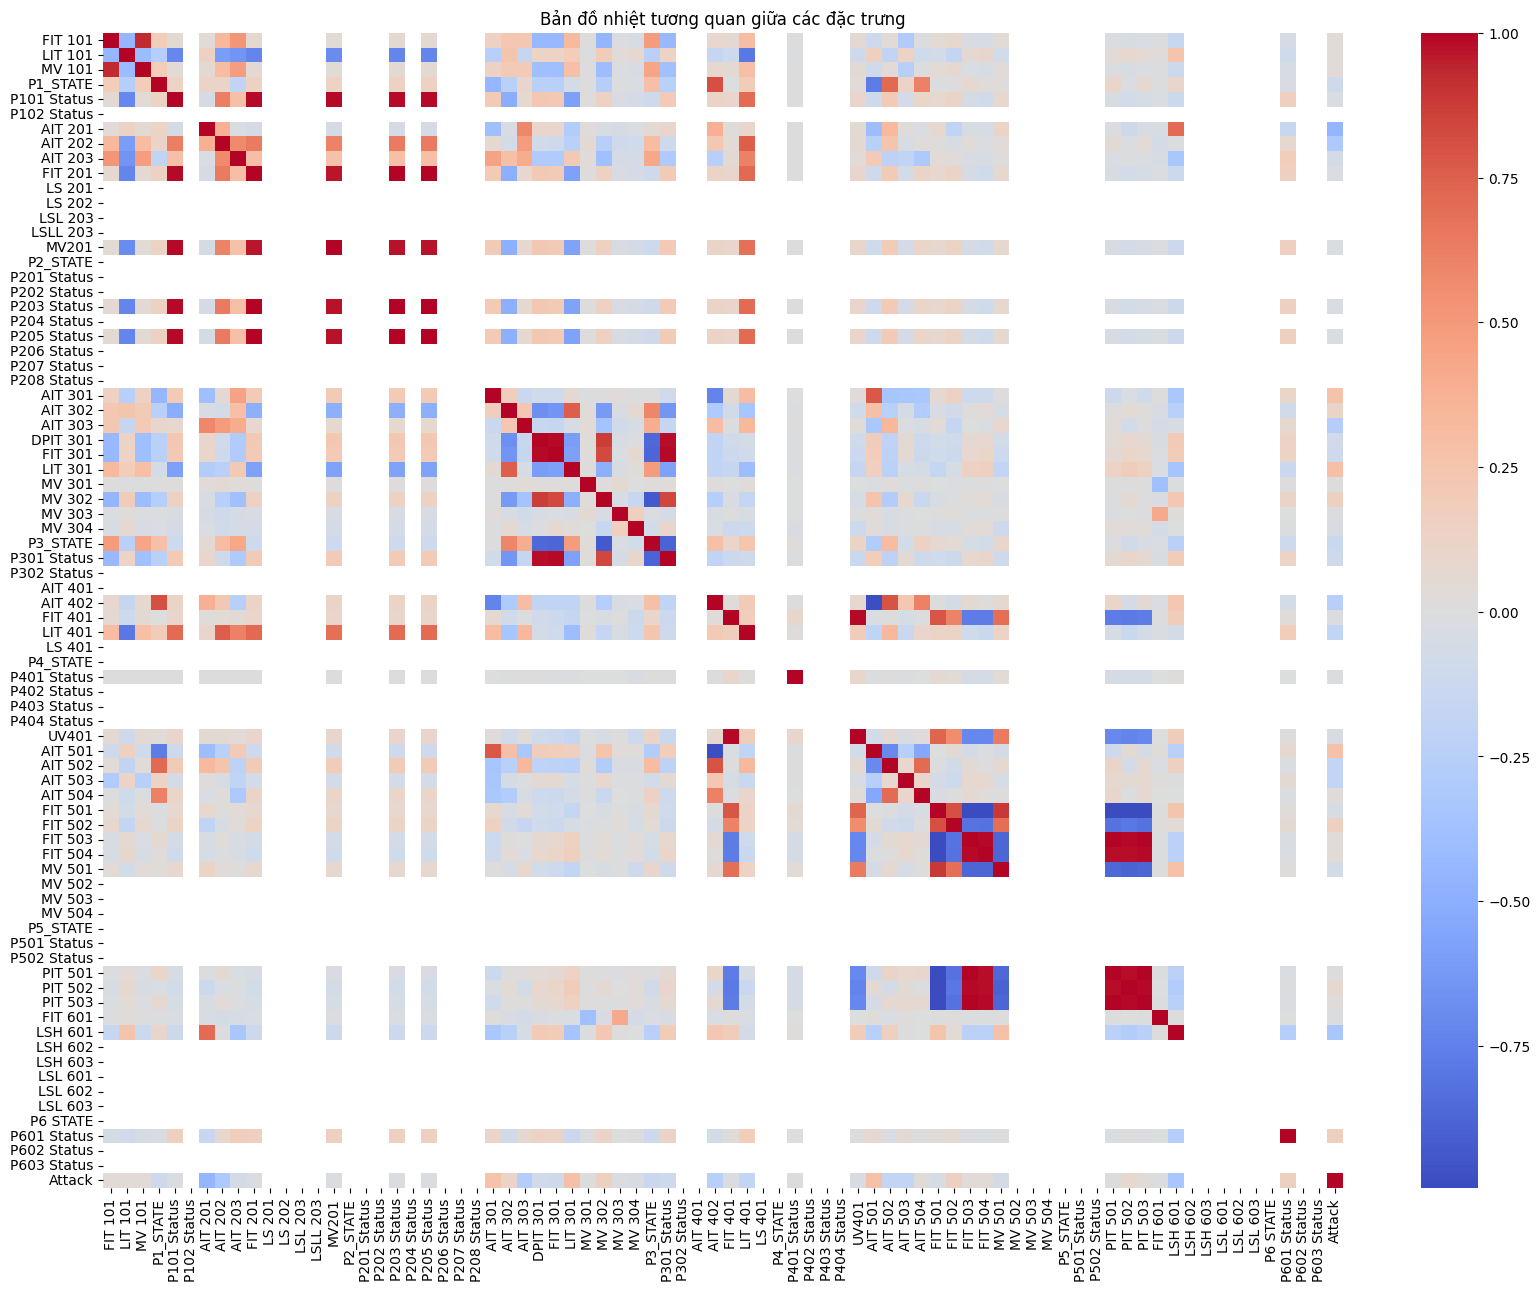

In [7]:
#--------------------------------------------------------------------------------\
# Feature correlations analysis

nan_columns = df.columns[df.isnull().all()]

if not nan_columns.empty:
    print("\nCÁC CỘT BỊ TRỐNG TRÊN HEATMAP (do toàn giá trị NaN):")
    print(list(nan_columns))
else:
    print("\nKhông tìm thấy cột nào chứa toàn giá trị NaN.")

corr_matrix = df.corr() 

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

plt.title('Bản đồ nhiệt tương quan giữa các đặc trưng')

plt.show()

In [8]:
#---------------------------------------------------------------------------------
# Select top features based on correlation with 'Attack'

selected_features = ['FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'MV201', 'P203 Status', 'P205 Status',
                    'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 
                    'AIT 402', 'FIT 401', 'LIT 401', 'P401 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503',
                    'FIT 504', 'MV 501', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'P601 Status']


df_model = df[selected_features + ['Attack']].copy()

print(f"Đã tạo DataFrame mới với {len(selected_features)} đặc trưng được chọn.")

print(df_model.head())


Đã tạo DataFrame mới với 44 đặc trưng được chọn.
                                  FIT 101   LIT 101  ...  P601 Status  Attack
GMT +0                                               ...                     
2019-07-20 04:30:00+00:00             0.0  729.8658  ...            1       0
2019-07-20 04:30:01+00:00             0.0  729.4340  ...            1       0
2019-07-20 04:30:02.004013+00:00      0.0  729.1200  ...            1       0
2019-07-20 04:30:03.004013+00:00      0.0  728.6882  ...            1       0
2019-07-20 04:30:04+00:00             0.0  727.7069  ...            1       0

[5 rows x 45 columns]


In [9]:
#---------------------------------------------------------------------------------
# missing value imputation


print(f"Số giá trị NaN trước khi xử lý: {df_model.isnull().sum().sum()}")

df_model.ffill(inplace=True)

df_model.bfill(inplace=True)

print(f"Số giá trị NaN sau khi xử lý: {df_model.isnull().sum().sum()}")

Số giá trị NaN trước khi xử lý: 0
Số giá trị NaN sau khi xử lý: 0


In [10]:
#- ---------------------------------------------------------------------------
# Split data into train and test sets based on time

split_timestamp = pd.to_datetime('2019-07-20 07:00:00').tz_localize("UTC")

df_train = df_model.loc[df_model.index <= split_timestamp]

df_test = df_model.loc[df_model.index > split_timestamp]

print("split timestamp:", split_timestamp)
print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")

split timestamp: 2019-07-20 07:00:00+00:00
Train set: (8996, 45), Test set: (6000, 45)


In [11]:
# label distribution

print("\n--- Phân bố nhãn trong tập train ---")
print(df_train['Attack'].value_counts())

print("\n--- Phân bố nhãn trong tập test ---")
print(df_test['Attack'].value_counts())

X_train = df_train[selected_features]
y_train = df_train['Attack']

X_test = df_test[selected_features]
y_test = df_test['Attack']

print("Completed data preprocessing and splitting!")


--- Phân bố nhãn trong tập train ---
Attack
0    8996
Name: count, dtype: int64

--- Phân bố nhãn trong tập test ---
Attack
0    4019
1    1981
Name: count, dtype: int64
Completed data preprocessing and splitting!


In [12]:
#---------------------------------------------------------------------------------
# Chuẩn hóa dữ liệu(data scaling)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dữ liệu đã được chuẩn hóa.")


Dữ liệu đã được chuẩn hóa.


In [13]:
#Train Autoencoder model 
#---------------------------------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Design and build the autoencoder

input_dim = X_train_scaled.shape[1]

input_layer = Input(shape=(input_dim,))

encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder) # bottleneck layer

decoder = Dense(32, activation="relu")(encoder)
decoder = Dense(input_dim, activation=None)(decoder) # output layer

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 44)             │         1,452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964 (15.48 KB)

 Trainable params: 3,964 (15.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3899 - val_loss: 0.2182
Epoch 2/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1154 - val_loss: 0.1843
Epoch 3/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0768 - val_loss: 0.1454
Epoch 4/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0581 - val_loss: 0.1297
Epoch 5/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0456 - val_loss: 0.1117
Epoch 6/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.0393 - val_loss: 0.1020
Epoch 7/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0354 - val_loss: 0.0950
Epoch 8/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0323 - val_loss: 0.0828
Epoch 9/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0296 - val_loss: 0.0803
Epoch 10/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0276 - val_loss: 0.0763
Epoch 11/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0257 - val_loss: 0.0707
Epoch 12/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

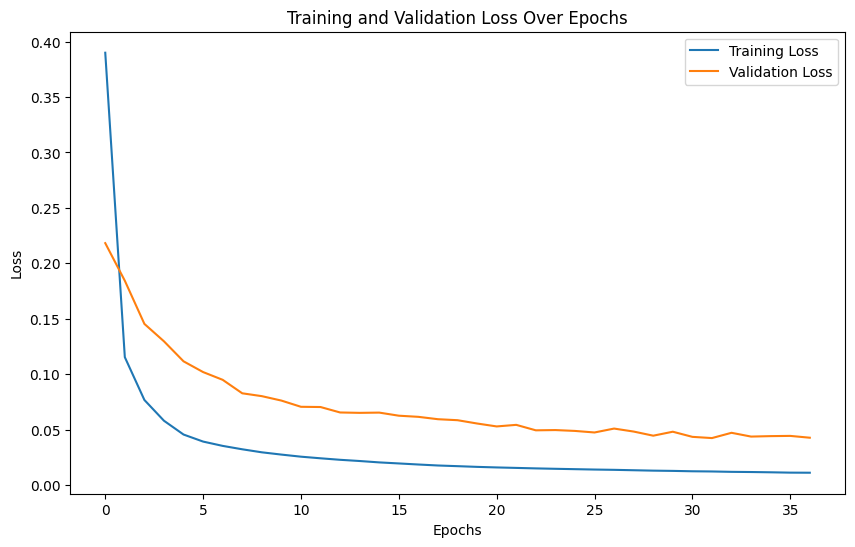

In [14]:
#---------------------------------------------------------------------------------
# Train the autoencoder

EarlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping],
    shuffle=True
)

print("Autoencoder model trained!")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


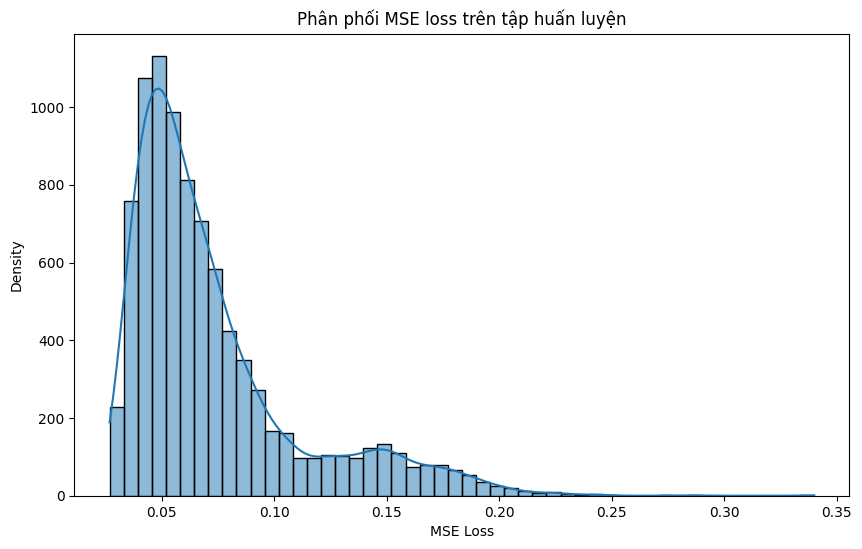


Ngưỡng lỗi tái tạo được xác định là: 0.2071


In [15]:
#---------------------------------------------------------------------------------
# Anomaly thresholding and evaluation

train_predictions = autoencoder.predict(X_train_scaled)
train_mse_loss = np.mean(np.abs(X_train_scaled - train_predictions), axis=1)  

plt.figure(figsize=(10, 6))

sns.histplot(train_mse_loss, bins=50, kde=True)
plt.title('Phân phối MSE loss trên tập huấn luyện')

plt.xlabel('MSE Loss')
plt.ylabel('Density')

plt.show()

threshold = np.percentile(train_mse_loss, 99.5)

print(f"\nNgưỡng lỗi tái tạo được xác định là: {threshold:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step

---Báo cáo phân loại(Autoencoder)---
              precision    recall  f1-score   support

   Normal(0)       0.98      0.17      0.29      4019
   Attack(1)       0.37      0.99      0.54      1981

    accuracy                           0.44      6000
   macro avg       0.68      0.58      0.42      6000
weighted avg       0.78      0.44      0.37      6000

Precision (for Attack class): 0.3712
Recall (for Attack class): 0.9939
F1-Score (for Attack class): 0.5406

--- Ma trận nhầm lẫn (Autoencoder) ---


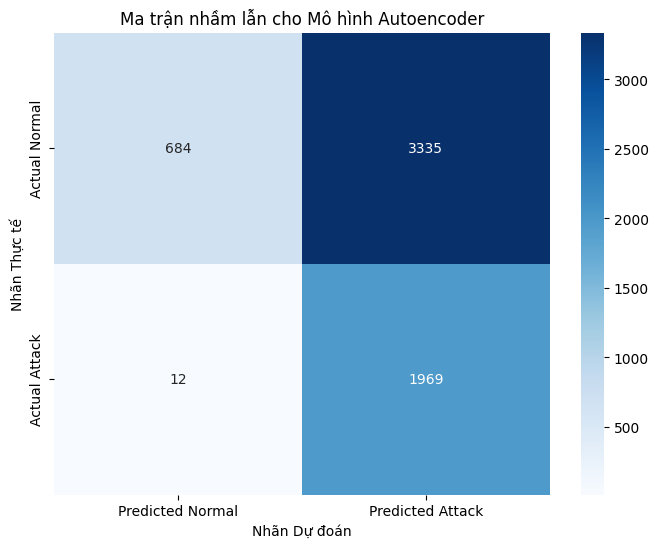

In [16]:
#---------------------------------------------------------------------------------
# Evaluate the model

test_predictions = autoencoder.predict(X_test_scaled)
test_mae_loss = np.mean(np.abs(X_test_scaled - test_predictions), axis=1)

test_predictions_mapped = (test_mae_loss > threshold).astype(int)

print("\n---Báo cáo phân loại(Autoencoder)---")
print(classification_report(y_test, test_predictions_mapped, target_names=['Normal(0)', 'Attack(1)']))

print(f"Precision (for Attack class): {precision_score(y_test, test_predictions_mapped):.4f}")
print(f"Recall (for Attack class): {recall_score(y_test, test_predictions_mapped):.4f}")
print(f"F1-Score (for Attack class): {f1_score(y_test, test_predictions_mapped):.4f}")

print("\n--- Ma trận nhầm lẫn (Autoencoder) ---")
cm_ae = confusion_matrix(y_test, test_predictions_mapped)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.title('Ma trận nhầm lẫn cho Mô hình Autoencoder')
plt.ylabel('Nhãn Thực tế')
plt.xlabel('Nhãn Dự đoán')
plt.show()


Ngưỡng tối ưu dựa trên F1-Score: 0.2407 với F1-Score: 0.5487


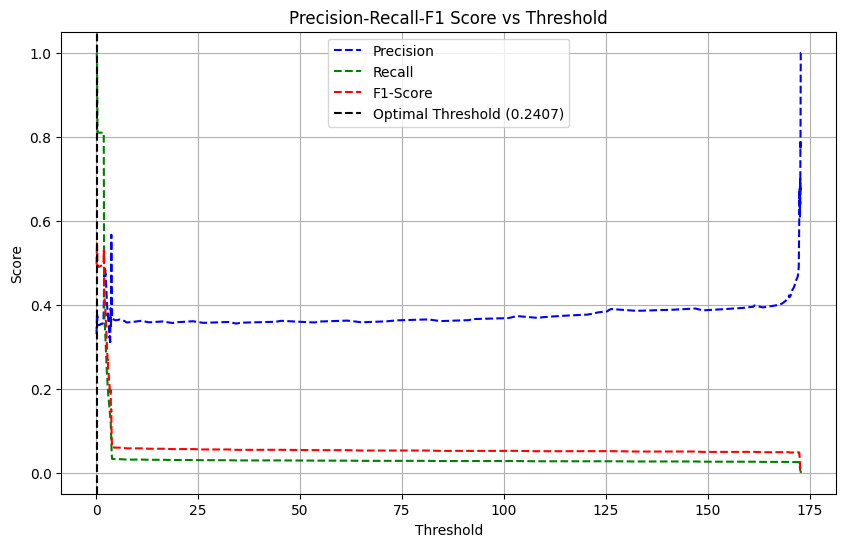

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

precisions, recalls, thresholds = precision_recall_curve(y_test, test_mae_loss)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Thêm epsilon để tránh chia cho 0

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
highest_f1 = f1_scores[optimal_idx]

print(f"\nNgưỡng tối ưu dựa trên F1-Score: {optimal_threshold:.4f} với F1-Score: {highest_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r--', label='F1-Score')
plt.axvline(optimal_threshold, color='k', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.4f})')S
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Score vs Threshold')
plt.legend()
plt.grid()
plt.show()